In [9]:
import pandas as pd
import numpy as np
import time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight

import sys
sys.path.append('../')
from backtest_functions_v2 import *

In [10]:
# Load the latest dataset
df = pd.read_parquet("../data/full_dataset_feature_engineering_v3.parquet")
print("Dataset loaded successfully.")
df.info()

Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35058 entries, 2021-01-01 06:00:00 to 2024-12-31 23:00:00
Columns: 149 entries, news_count to reddit_average_sentiment_ewm_100h
dtypes: float64(87), int32(1), int64(61)
memory usage: 40.0 MB


### Data Preparation and Splitting

In [11]:
# Use all features except target and forward return
all_features = df.columns.drop(['target', 'return_forward', 'year'])
print(f"Number of features: {len(all_features)}")

# Define training (2021-2023) and testing (2024) periods
df_train = df[df['year'].isin([2021, 2022, 2023])]
df_test = df[df['year'] == 2024]

X_train = df_train[all_features]
y_train = df_train['target']
X_test = df_test[all_features]
y_test = df_test['target']

# Print shapes and class distribution
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

Number of features: 146
X_train shape: (26274, 146)
y_train shape: (26274,)
X_test shape: (8784, 146)
y_test shape: (8784,)
Training set class distribution: [ 9993  6038 10243]
Test set class distribution: [2648 3274 2862]


### XGBoost Model with GridSearchCV

In [ ]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('model', xgb.XGBClassifier(
    objective='multi:softprob', # Output probabilities for each class
    eval_metric='mlogloss',     # Logloss for multiclass classification
    random_state=42,
    n_jobs=-1
  ))
])

# Parameter grid for GridSearchCV
param_grid = {
  'model__n_estimators': [100, 200, 300],
  'model__max_depth': [3, 5, 7, 9],
  'model__learning_rate': [0.01, 0.05, 0.1],
  'model__subsample': [0.7, 0.8, 0.9],
  'model__colsample_bytree': [0.7, 0.8, 0.9]

  # Regularization parameters:
  # 'model__gamma': [0, 0.1, 0.2],
  # 'model__reg_alpha': [0, 0.01, 0.1],
  # 'model__reg_lambda': [1, 1.1, 1.2]
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Compute sample weights for handling class imbalance during fitting
# This needs to be passed to the fit method, not as a model parameter
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
fit_params = {'model__sample_weight': sample_weights}

# Initialize GridSearchCV
grid_search = GridSearchCV(
  estimator=pipeline,
  param_grid=param_grid,
  cv=tscv,
  scoring='roc_auc_ovr_weighted',
  n_jobs=-1,
  verbose=1
)

# Fit GridSearchCV on the training data
print("Starting GridSearchCV for XGBoostClassifier...")
start_time = time.time()
# Pass fit_params to the fit method
grid_search.fit(X_train, y_train, **fit_params)
end_time = time.time()

print(f"\nGridSearchCV fitting time: {end_time - start_time:.2f} seconds")
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation ROC AUC score: ", grid_search.best_score_)

# Get the best estimator found by GridSearchCV
best_model = grid_search.best_estimator_

Starting GridSearchCV for XGBoostClassifier...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

GridSearchCV fitting time: 5681.57 seconds
Best parameters found:  {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.7}
Best cross-validation ROC AUC score:  0.595698507989571


### Feature Importance Analysis


Top 20 most important features:
                             Feature  Importance
48                            atr_14    0.080053
47                             atr_7    0.076426
66                     10_band_width    0.046090
68                     20_band_width    0.041288
60                     upper_band_10    0.025785
65                     lower_band_20    0.019278
63                     upper_band_20    0.018590
67                          pct_b_10    0.018169
19             ema_5_20_diff_abs_chg    0.017920
143  reddit_total_sentiment_ewm_100h    0.017239
49                       atr_7_slope    0.017067
64                    middle_band_20    0.016980
53               norm_price_change_7    0.016944
52                        atr_14_chg    0.016214
57             trailing_stop_long_14    0.015985
61                    middle_band_10    0.015756
21            ema_20_50_diff_abs_chg    0.015172
46                         rsi_ratio    0.014960
59            trailing_stop_short_14

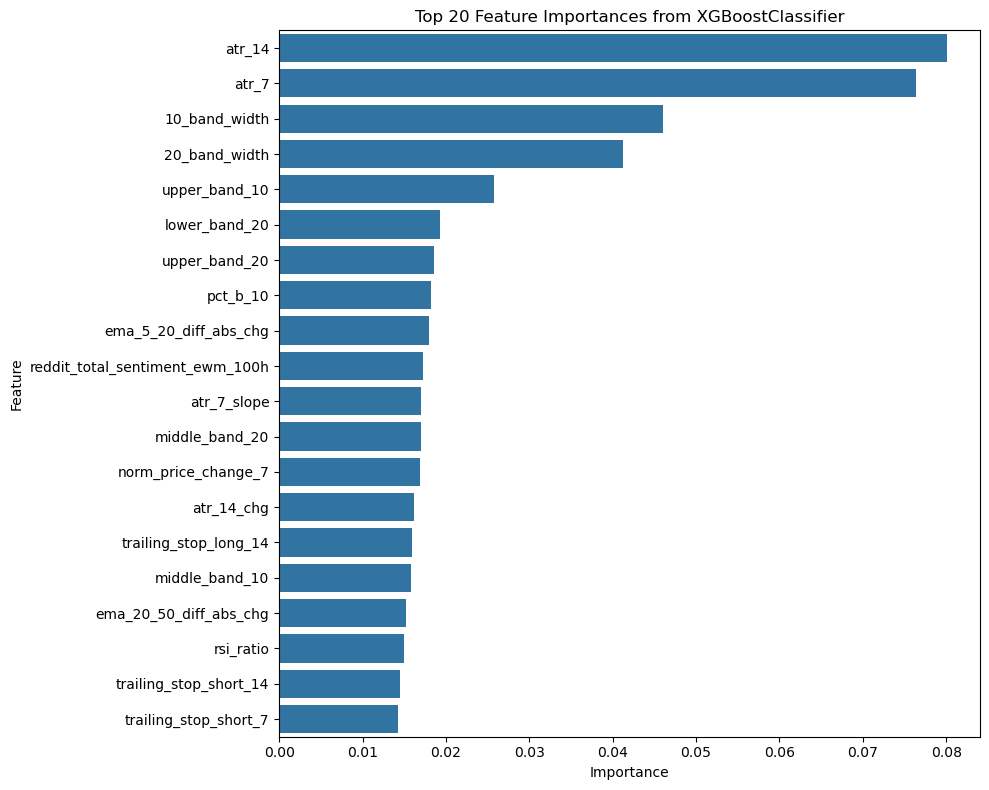

In [13]:
# Get feature importances from the best XGBoost model
importances = best_model.named_steps['model'].feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 20 most important features:")
print(importance_df.head(20))

# Plot top 20 feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances from XGBoostClassifier')
plt.tight_layout()
plt.show()

### Model Evaluation on Test Set


Predicting on the test set...
Prediction complete.

Test Set Evaluation:
Accuracy: 0.4908
ROC AUC Score (One-vs-Rest): 0.6939

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.38      0.54      0.44      2648
 Neutral (1)       0.77      0.48      0.59      3274
 Bullish (2)       0.44      0.46      0.45      2862

    accuracy                           0.49      8784
   macro avg       0.53      0.49      0.50      8784
weighted avg       0.55      0.49      0.50      8784


Confusion Matrix:
[[1426  213 1009]
 [1054 1570  650]
 [1298  249 1315]]


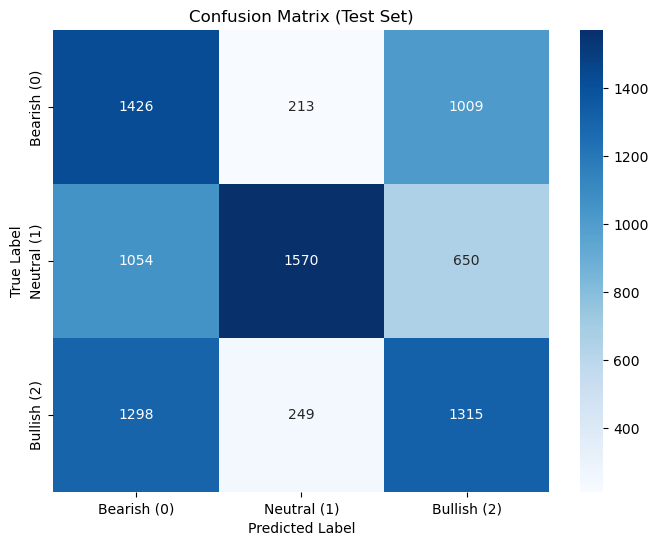

In [14]:
# Make predictions on the test set
print("\nPredicting on the test set...")
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)
print("Prediction complete.")

# Evaluate the model performance on the test set
accuracy = accuracy_score(y_test, y_pred)
class_names = ['Bearish (0)', 'Neutral (1)', 'Bullish (2)']
report = classification_report(y_test, y_pred, target_names=class_names)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score (One-vs-Rest): {roc_auc:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

### Monthly Accuracy Analysis


Monthly Accuracy (2024 Test Set):
2024-01-31    0.416667
2024-02-29    0.418103
2024-03-31    0.456989
2024-04-30    0.459722
2024-05-31    0.412634
2024-06-30    0.431944
2024-07-31    0.401882
2024-08-31    0.408602
2024-09-30    0.568056
2024-10-31    0.721774
2024-11-30    0.605556
2024-12-31    0.586022
Freq: ME, Name: correct_prediction, dtype: float64


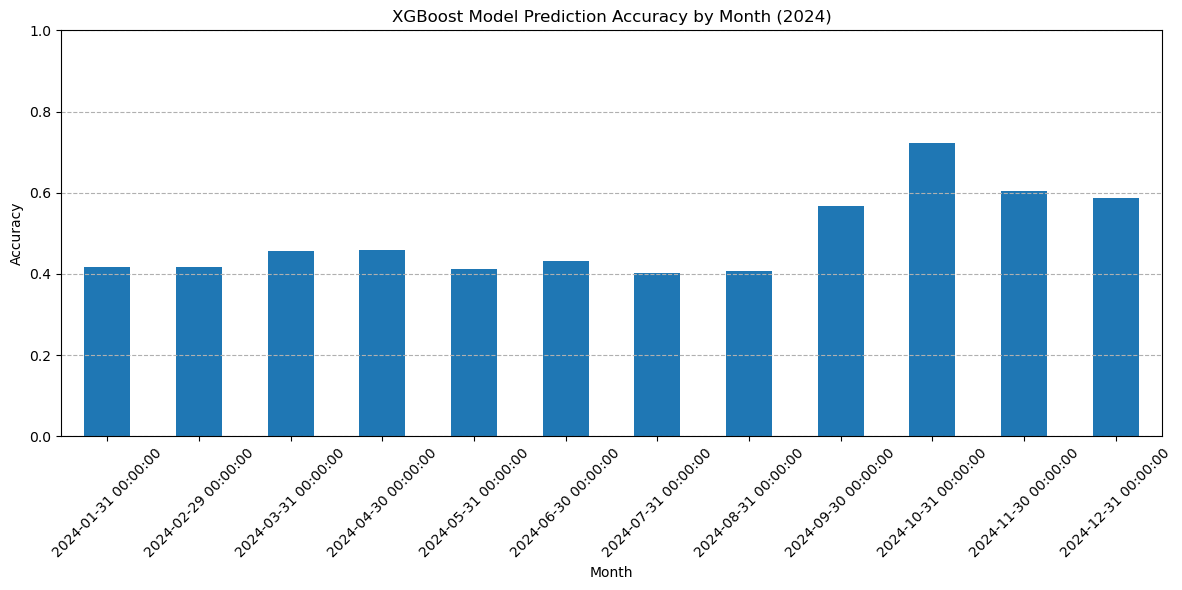


Sample of Test Results with Predictions:
                     target  predicted_class actual_label predicted_label  \
2024-01-01 00:00:00       0                1      Bearish         Neutral   
2024-01-01 01:00:00       1                1      Neutral         Neutral   
2024-01-01 02:00:00       0                1      Bearish         Neutral   
2024-01-01 03:00:00       1                2      Neutral         Bullish   
2024-01-01 04:00:00       2                2      Bullish         Bullish   

                     prob_bearish  prob_neutral  prob_bullish  
2024-01-01 00:00:00      0.344260      0.354735      0.301004  
2024-01-01 01:00:00      0.317327      0.362755      0.319918  
2024-01-01 02:00:00      0.314358      0.363401      0.322241  
2024-01-01 03:00:00      0.314517      0.320142      0.365341  
2024-01-01 04:00:00      0.320013      0.317707      0.362280  


In [15]:
# Add predictions and probabilities to the test dataframe for analysis
df_test_results = df_test.copy()

df_test_results.loc[:, 'predicted_class'] = y_pred
df_test_results.loc[:, 'prob_bearish'] = y_pred_proba[:, 0]
df_test_results.loc[:, 'prob_neutral'] = y_pred_proba[:, 1]
df_test_results.loc[:, 'prob_bullish'] = y_pred_proba[:, 2]

# Map numerical target/prediction to labels for clarity
target_map = {0: 'Bearish', 1: 'Neutral', 2: 'Bullish'}
df_test_results.loc[:, 'actual_label'] = df_test_results['target'].map(target_map)
df_test_results.loc[:, 'predicted_label'] = df_test_results['predicted_class'].map(target_map)

# Calculate if the prediction was correct
df_test_results.loc[:, 'correct_prediction'] = (df_test_results['target'] == df_test_results['predicted_class']).astype(int)

# --- Monthly Accuracy Analysis ---
if isinstance(df_test_results.index, pd.DatetimeIndex):
    # Ensure the index is timezone-naive or handle conversion if necessary
    if df_test_results.index.tz is not None:
        df_test_results.index = df_test_results.index.tz_localize(None)
        
    monthly_accuracy = df_test_results.resample('ME')['correct_prediction'].mean()
    
    print("\nMonthly Accuracy (2024 Test Set):")
    print(monthly_accuracy)
    
    plt.figure(figsize=(12, 6))
    monthly_accuracy.plot(kind='bar')
    plt.title('XGBoost Model Prediction Accuracy by Month (2024)')
    plt.ylabel('Accuracy')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    plt.ylim(0, 1) # Set y-axis limits for better comparison
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("Index is not DatetimeIndex. Skipping monthly accuracy plot.")

# Display some results
print("\nSample of Test Results with Predictions:")
print(df_test_results[['target', 'predicted_class', 'actual_label', 'predicted_label', 'prob_bearish', 'prob_neutral', 'prob_bullish']].head())

### Backtesting the Strategy

Sample signals for backtesting:
                     target  predicted_class  signal
2024-01-01 00:00:00       0                1       0
2024-01-01 01:00:00       1                1       0
2024-01-01 02:00:00       0                1       0
2024-01-01 03:00:00       1                2       1
2024-01-01 04:00:00       2                2       1

Predicted signal distribution for backtest:
signal
-1    3778
 1    2974
 0    2032
Name: count, dtype: int64
Overall Annual Return: 33.98%
Overall Annual Sharpe Ratio: 0.8428
Maximum Drawdown: -37.48 %
Alpha: 0.4968
Beta: 0.0095

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.339797    0.489073     0.009506      0.403337       0.842791


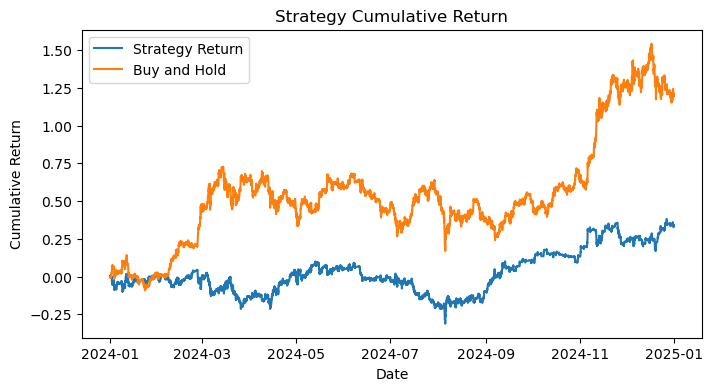

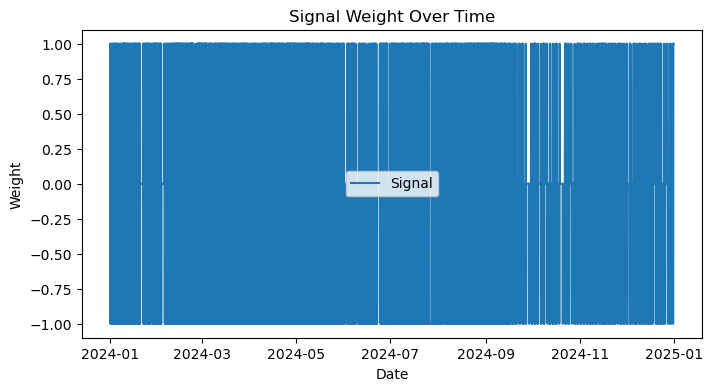

In [16]:
# Prepare dataframe for backtesting
df_backtest = df_test_results.copy()

# Map predicted class to trading signal: 0 -> -1 (Short), 1 -> 0 (Neutral), 2 -> 1 (Long)
df_backtest['signal'] = df_backtest['predicted_class'] - 1

# Display the first few rows with the new signal column
print("Sample signals for backtesting:")
print(df_backtest[['target', 'predicted_class', 'signal']].head())

# Check the distribution of the generated signals
print("\nPredicted signal distribution for backtest:")
print(df_backtest['signal'].value_counts())


run_backtest(df_backtest, freq='h')